Test to see if training the networks on a more ellpiticity distribution uniform than it really is would decrease the bias observed: 

---> YES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import logging
import galsim
import random
import cmath as cm
import math
import scipy
import scipy.stats as stats
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
%matplotlib inline
import tensorflow as tf
import seaborn as sns

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 

In [2]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
import tools_for_VAE

from tools_for_VAE import vae_functions, model, plot, generator, utils

from tools_for_VAE.model import build_encoder, build_decoder
from tools_for_VAE.utils import load_vae_conv, denorm, norm
from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, createCircularMask, mean_var, plot_corner_latent


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [4]:
from tools_for_VAE.results_processing import processing

In [6]:
from importlib import reload
reload(plot)

from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, createCircularMask, mean_var, plot_corner_latent

# Generators

In [202]:
list_of_samples_new=['/sps/lsst/users/barcelin/data/isolated_galaxies/centered/training/galaxies_isolated_20191024_2_images.npy']

In [183]:
test = np.load(list_of_samples_new[0], mmap_mode = 'c')

In [184]:
test.shape

(10000, 2, 10, 64, 64)

In [203]:
list_of_weights = ['/sps/lsst/users/barcelin/data/isolated_galaxies/centered/training/weights/weights_3.npy']

In [204]:
w = np.load('/sps/lsst/users/barcelin/data/isolated_galaxies/centered/training/weights/weights_2.npy')

In [205]:
print(w.shape,np.sum(w))

(10000,) 9740.230449242303


In [206]:
w

array([0.5245669 , 0.57978031, 0.52132678, ..., 0.51986215, 0.7965649 ,
       0.57703486])

In [207]:
bands_lsst = [4,5,6,7,8,9]

In [208]:
reload(generator)

<module 'tools_for_VAE.generator' from '../../scripts/tools_for_VAE/tools_for_VAE/generator.py'>

In [209]:
batch_gen_lsst = generator.BatchGenerator(bands_lsst, list_of_samples_new, total_sample_size=None,
                                    batch_size=100, 
                                    trainval_or_test='validation', 
                                    do_norm=False, 
                                    denorm = False,
                                    list_of_weights_e= list_of_weights)

[BatchGenerator] total_sample_size =  10000
[BatchGenerator] len(list_of_samples) =  1


In [210]:
phys_stamp_size = 6.4 # arcsec
pixel_scale_euclid_vis = 0.1 # arcsec/pixel

stamp_size = int(phys_stamp_size/pixel_scale_euclid_vis)

# Test plot for LSST all filters

In [211]:
def compute_e (galaxies):
    PSF = galsim.Kolmogorov(fwhm=0.65)
    r_band = 2
    pix_scale = 0.2
    #final_epsf_image = PSF.drawImage(scale=0.2)

    psf_image = PSF.drawImage(nx=64, ny=64, scale=0.2)
    e = []
    error_list = []
    for i in range(len(galaxies)):
        #try : 
        gal_image = galsim.Image(galaxies[i][:,:,r_band])
        gal_image.scale = pix_scale

        # Measurements of shapes
        shear_est = 'KSB'
        res = galsim.hsm.EstimateShear(gal_image, psf_image, shear_est=shear_est, strict=True)
        e_beta_in = [np.sqrt(res.corrected_g1**2+res.corrected_g2**2)]
        e.append(e_beta_in)

    return np.array(e)#,  error_list

In [212]:
e = []
for i in range (100):
    input_vae = batch_gen_lsst.__getitem__(2)
    input_noiseless = denorm(input_vae[1], bands_lsst, channel_last = True, n_years = 5)
    #input_noiseless = input_vae[1]
    e.append(compute_e(input_noiseless))

In [213]:
e = np.concatenate(np.concatenate(e))

In [214]:
e.shape

(10000,)

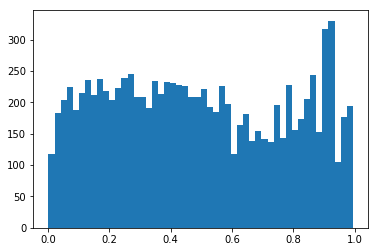

In [215]:
_ = plt.hist(e, bins = 50)

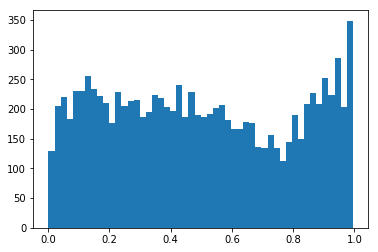

In [181]:
_ = plt.hist(e, bins = 50)

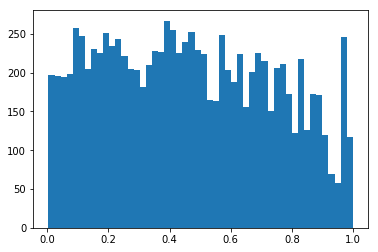

In [164]:
_ = plt.hist(e, bins = 50)

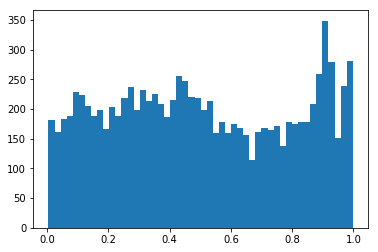

In [82]:
_ = plt.hist(e, bins = 50)